Loads libraries into namespace and applies a white-grid style so plots are legible.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import numpy as np

sns.set(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# if cuda is available for better computation

Since GitHub couldn't accommodate the large file size, the data has been uploaded to the cloud and can be accessed via the following link- https://drive.google.com/drive/folders/1QMg0btA1040BB02AFiqVzrjLRrGx8ZJG?usp=sharing

### Data Acquisition and Merging

In this step, we collect all the yearly rainfall data files (CSV format) from the IMERG dataset folder and combine them into one dataset.  
Each file represents daily rainfall for a single year, so by reading them all and merging together, we create a single continuous dataset covering the full study period (1998–2024).  
This ensures that the data is in one place and ready for preprocessing, analysis, and feature engineering.


In [ ]:
# Path to your folder — update this if it's different
data_folder = r"C:\Users\chhaj\OneDrive\Desktop\shubham files\AfricaIMERG_onedeg1998to2024"
# Get all CSV file paths
csv_files = sorted([f for f in os.listdir(data_folder) if f.endswith(".CSV")])
# Read and merge all the CSV files
all_data = []
for file in csv_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    all_data.append(df)
# Combine all years into one DataFrame
df = pd.concat(all_data, ignore_index=True)
df.head()

Above code will generate the following output

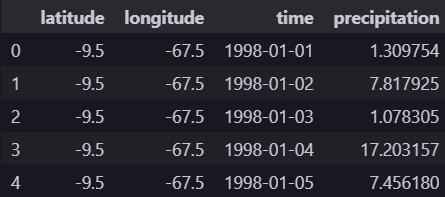

### Preview of the Merged Dataset

The table above shows the first five rows of the combined rainfall dataset.  
- **latitude** and **longitude** identify the grid cell location in tropical Africa.  
- **time** represents the daily timestamp (starting from 1 January 1998).  
- **precipitation** gives the rainfall amount (in millimetres) recorded for that day.  

This confirms that the merging worked correctly and we now have a continuous daily time series across locations.


### Converting and Sorting the Time Column

The dataset includes a `time` column, but by default it may be stored as a string.  
Here we convert it into a proper `datetime` format so that time-based operations (like sorting, feature engineering, and rolling averages) work correctly.  
After conversion, we sort the entire dataset chronologically and reset the index to maintain a clean structure.  


In [ ]:
# Convert 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])
# Sort by time
df = df.sort_values(by='time')
df.reset_index(drop=True, inplace=True)
df.info()

Above code will generate the following output

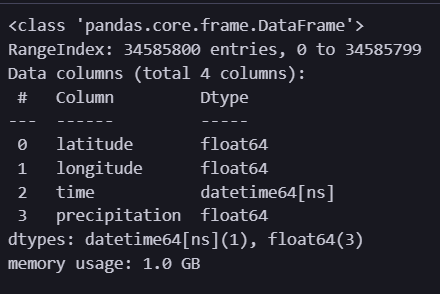

The output above shows the structure of the dataset after converting and sorting the `time` column:  
- **latitude** and **longitude** are stored as floats.  
- **time** is now properly stored as `datetime64`.  
- **precipitation** remains as a float.  
- The dataset contains around 34.5 million rows and uses about 1 GB of memory.  

This confirms that the dataset is consistent and ready for further analysis.


### Checking Data Integrity: Missing Values and Dates

Before analysis, it is important to confirm that the dataset has no missing or inconsistent entries.  
Here, we perform two checks:  
1. **Column-wise missing values** – to ensure that `latitude`, `longitude`, `time`, and `precipitation` fields are complete.  
2. **Time continuity check** – to confirm that there are no missing dates in the daily time series.  


In [ ]:
# Checking for missing values in any column
print("Missing Values Summary:")
print(df.isnull().sum())
# Ensuring daily frequency is consistent
date_range = pd.date_range(start=df['time'].min(), end=df['time'].max(), freq='D')
actual_dates = df['time'].sort_values()
# Compare expected vs actual
missing_dates = set(date_range) - set(actual_dates)
print(f"\nMissing Dates in Time Series: {len(missing_dates)}")
# show a few missing dates if there are any
if missing_dates:
    print("Example missing dates:", sorted(list(missing_dates))[:10])

Above code will generate the following output

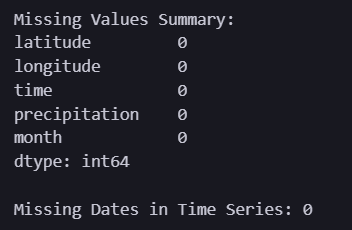

The summary shows that:  
- No missing values are present in any of the columns.  
- No gaps are found in the daily time series — every date between the start and end of the dataset is included.  

This confirms that the dataset is complete and suitable for further exploratory data analysis and feature engineering.  


### Ensuring Consistent Date Features

To make sure the dataset is fully ready for time-based analysis, we perform a few additional steps:  
- Convert the `time` column into a proper `datetime` object called `date`.  
- Extract useful date-related features such as **year** and **day of year (doy)**.  
- Sort the dataset by date to maintain chronological order.  

These steps guarantee that all time-dependent operations, like seasonal analysis and model training, use a clean and consistent timeline.  


In [ ]:
# Convert 'time' to datetime
df['date'] = pd.to_datetime(df['time'])
# Create 'year' and 'doy' if not already done (you have 'year' and 'dayofyear' already, but for safety):
df['year'] = df['date'].dt.year
df['doy'] = df['date'].dt.dayofyear
# Sort by time
df = df.sort_values('date')

## Exploratory Data Analysis (EDA)

Before building predictive models, it is essential to explore the dataset to understand its main characteristics.  
EDA helps us:  
- Visualise rainfall behaviour over time,  
- Identify seasonal and long-term trends,  
- Detect any anomalies or extreme events, and  
- Confirm that the dataset is suitable for feature engineering and modelling.  

We begin by plotting the full daily precipitation series to get an overview of variability and patterns across the study period.  


In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['time'], df['precipitation'], linewidth=0.5)
plt.title("Daily Precipitation (1998–2024)")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

Above code will generate the following output

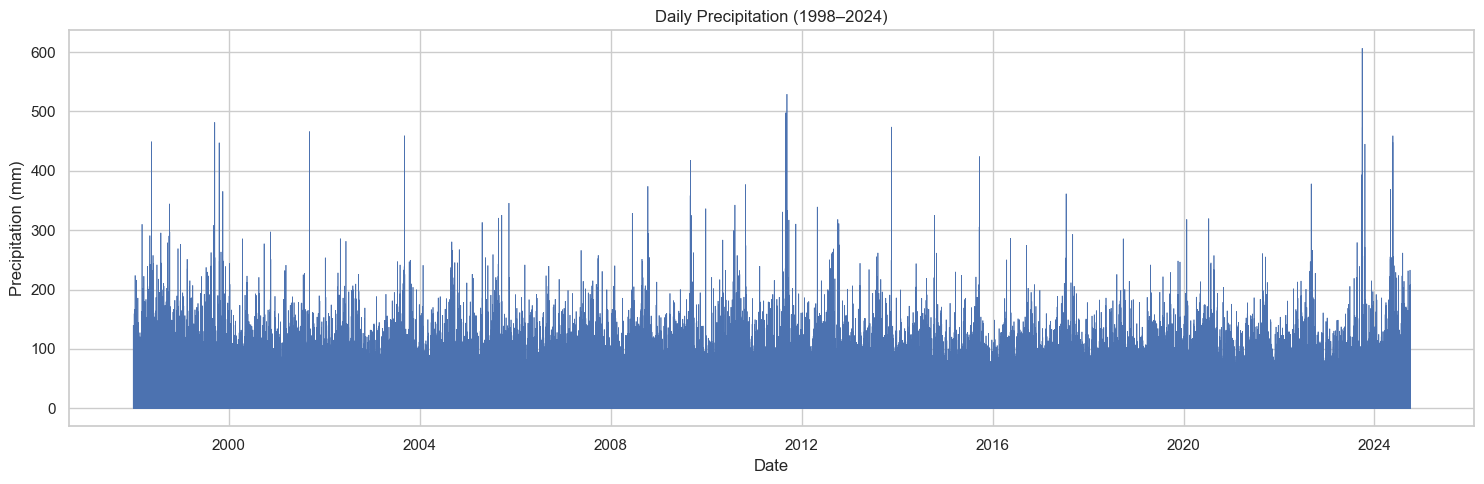


This plot shows the daily precipitation values across the entire study period.  
- The rainfall pattern is highly variable from day to day, reflecting the convective nature of tropical storms.  
- We can also see extreme rainfall spikes, which correspond to heavy storm events.  
- Despite this variability, the data remains continuous, confirming the reliability of the dataset for further analysis.  


In [ ]:
df['month'] = df['time'].dt.month
plt.figure(figsize=(10, 5))
sns.boxplot(x='month', y='precipitation', data=df)
plt.title("Monthly Precipitation Distribution (1998–2024)")
plt.xlabel("Month")
plt.ylabel("Precipitation (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

Above code will generate the following output

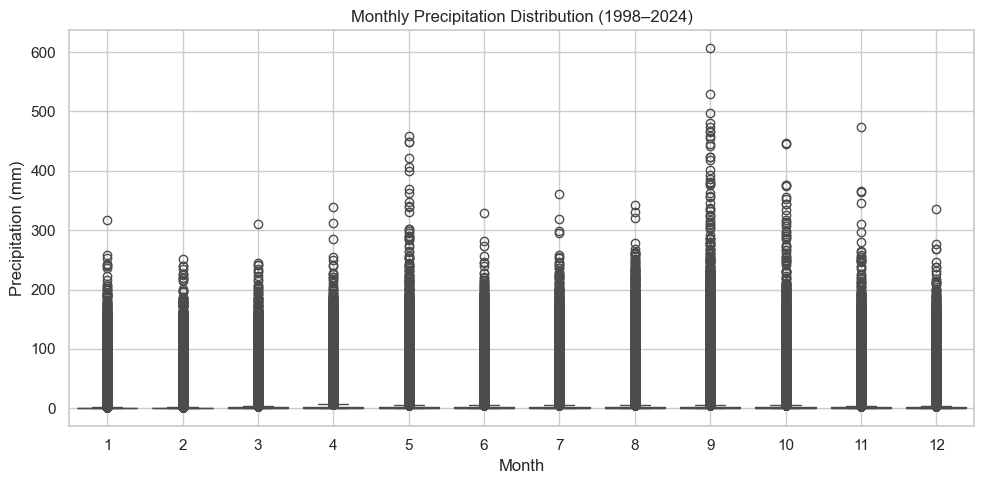


This boxplot shows how precipitation varies across different months of the year.  
- The boxes represent the spread of rainfall values, while the whiskers and outliers highlight extreme events.  
- We can clearly see wetter months with higher median rainfall (such as July–September) compared to drier months (like January–February).  
- This seasonal pattern is consistent with the main rainy season and dry season in tropical Africa, and it confirms the strong seasonality that will be important for feature engineering.  


### Creating Lagged Features

Rainfall in the tropics often shows short-term persistence — if it rains today, it is more likely to rain tomorrow or within the next few days.  
To capture this dependency, we create **lagged features**, which store the precipitation values from previous days.  
These lagged values help machine learning models learn short-term patterns and improve predictive performance.  
Here, we generate two lag features:  
- **precip_lag1** → yesterday’s rainfall (t−1)  
- **precip_lag2** → rainfall from two days ago (t−2)  


In [ ]:
# Create lag features for t-1 and t-2
df['precip_lag1'] = df['precipitation'].shift(1)
df['precip_lag2'] = df['precipitation'].shift(2)
# Check result
df[['time', 'precipitation', 'precip_lag1', 'precip_lag2']].head()

Above code will generate the following output

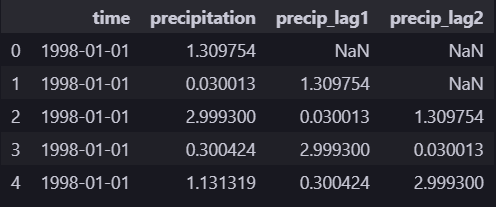

The preview shows the `precip_lag1` and `precip_lag2` columns alongside the original `precipitation`:  
- For the first row, lag values are `NaN` because there is no prior data before 1 January 1998.  
- From the second row onwards, `precip_lag1` correctly shifts yesterday’s rainfall, and `precip_lag2` shifts the rainfall from two days earlier.  

These new features provide the model with short-term memory of rainfall behaviour.  


### Categorising Rainfall into Classes (Binning)

Instead of predicting the exact rainfall amount (in millimetres), we simplify the task by grouping daily rainfall into three categories:  
- **No** → 0 mm  
- **Light** → rainfall up to 10 mm  
- **Strong** → rainfall greater than 10 mm  

This approach makes the prediction problem more practical, since in real applications it is often more useful to know whether a day will be dry, rainy, or experience heavy rainfall.  
Here, we apply this binning both to the current precipitation values and to the lagged features.  


In [ ]:
# Define binning function
def bin_precip(value):
    if value == 0:
        return "No"
    elif value <= 10:
        return "Light"
    else:
        return "Strong"
# Apply to current and lag features
df['precip_bin'] = df['precipitation'].apply(bin_precip)
df['precip_lag1_bin'] = df['precip_lag1'].apply(bin_precip)
df['precip_lag2_bin'] = df['precip_lag2'].apply(bin_precip)
# Preview
df[['time', 'precip_bin', 'precip_lag1_bin', 'precip_lag2_bin']].head(10)

Above code will generate the following output

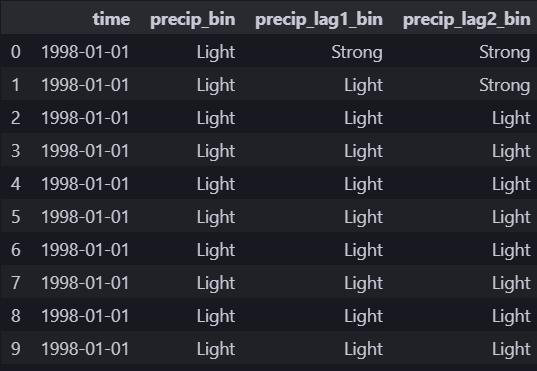

The preview shows the new categorical columns:  
- **precip_bin** → today’s rainfall category  
- **precip_lag1_bin** → yesterday’s rainfall category  
- **precip_lag2_bin** → rainfall category from two days earlier  

For example, if precipitation was less than or equal to 10 mm, it is classified as **Light**, while values above 10 mm are **Strong**.  
This transformation helps the models work with clearer, event-based classes instead of continuous values.  


### Creating Rolling Average Features

Daily rainfall values are highly irregular — some days have no rain, while others experience sudden heavy downpours.  
To reduce this noise and capture broader trends, we compute **rolling averages** over different time windows:  
- **3-day rolling average** → captures short wet or dry spells,  
- **7-day rolling average** → reflects weekly rainfall behaviour,  
- **30-day rolling average** → highlights longer seasonal build-up and decline.  

These features help the models learn both short-term persistence and long-term seasonal cycles in rainfall.  


In [ ]:
df['precipitation'] = df['precipitation'].astype('float32')
df['rolling_3day'] = df['precipitation'].rolling(3).mean()
df['rolling_7day'] = df['precipitation'].rolling(7).mean()
df['rolling_30day'] = df['precipitation'].rolling(30).mean()

# Drop NaNs from all rolling columns
df.dropna(subset=['rolling_3day', 'rolling_7day', 'rolling_30day'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Plotting recent year for clarity (e.g., 2023 only)
recent = df[df['time'].dt.year == 2023]

plt.figure(figsize=(14, 6))
plt.plot(recent['time'], recent['precipitation'], label='Daily', alpha=0.5)
plt.plot(recent['time'], recent['rolling_3day'], label='3-Day Rolling Avg')
plt.plot(recent['time'], recent['rolling_7day'], label='7-Day Rolling Avg')
plt.plot(recent['time'], recent['rolling_30day'], label='30-Day Rolling Avg')
plt.title('Precipitation with Rolling Averages (2023)')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Above code will generate the following output

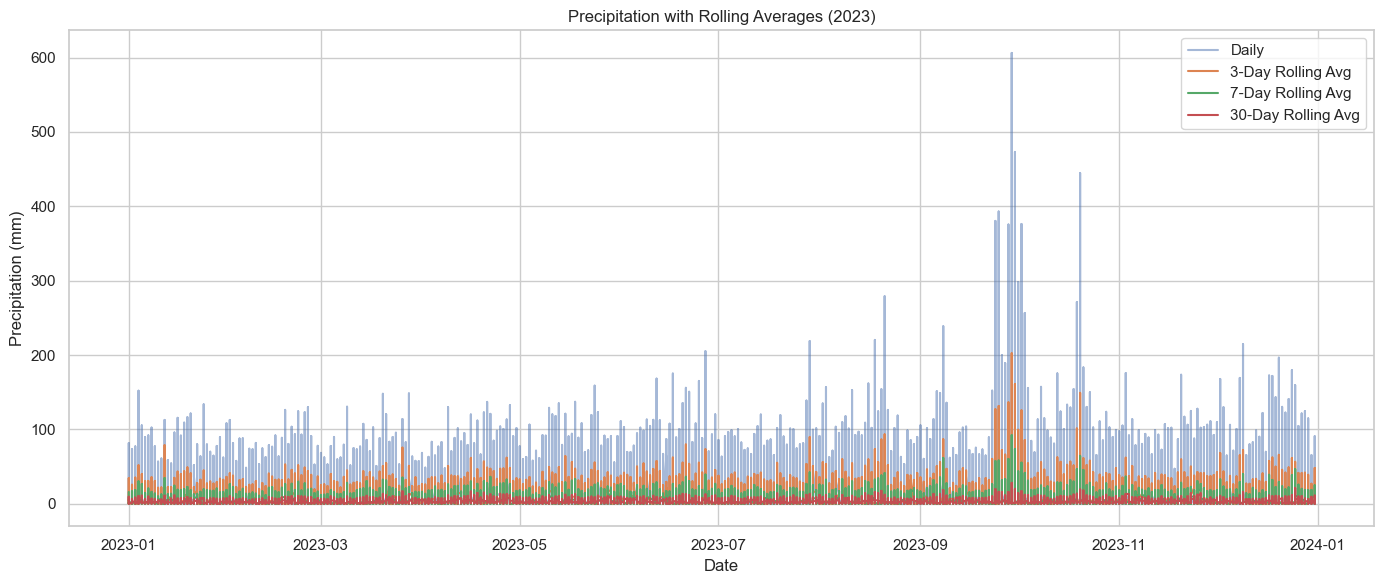

This plot shows daily precipitation in 2023 together with its 3-day, 7-day, and 30-day rolling averages.  
- The **blue line** (daily values) is highly variable, with sharp rainfall spikes caused by individual storm events.  
- The **orange 3-day average** smooths out short clusters of rainfall.  
- The **green 7-day average** highlights weekly rainfall patterns.  
- The **red 30-day average** reveals the broader seasonal trend, capturing gradual build-up and decline of rainfall.  

By comparing these curves, we can see how rolling averages help reduce noise and make seasonal patterns clearer for the models.

### Encoding Seasonality with Cyclical Features

Rainfall in tropical regions follows a strong seasonal cycle, with wet and dry periods repeating each year.  
To capture this pattern, we add **seasonality features** to the dataset:  

- **dayofyear** → numeric day (1–365) of each observation.  
- **sin_doy** and **cos_doy** → sine and cosine transformations of `dayofyear`, which encode the annual cycle as a smooth loop.  
  - This avoids the artificial jump between December (day 365) and January (day 1), since sine/cosine naturally wrap around.  

We also keep additional time markers such as **month**, **weekofyear**, and **year** for flexibility in later analysis.  
These features help the models recognise repeating seasonal rainfall behaviour.  


In [ ]:
# Day of year
df['dayofyear'] = df['time'].dt.dayofyear

# Encode as sine and cosine to reflect cyclic pattern (0 to 2π)
df['sin_doy'] = np.sin(2 * np.pi * df['dayofyear'] / 365.25)
df['cos_doy'] = np.cos(2 * np.pi * df['dayofyear'] / 365.25)

# Optional additional markers
df['month'] = df['time'].dt.month
df['weekofyear'] = df['time'].dt.isocalendar().week
df['year'] = df['time'].dt.year

In [ ]:
# Group by day of year and plot mean precipitation
seasonal_avg = df.groupby('dayofyear')['precipitation'].mean()

plt.figure(figsize=(10, 4))
plt.plot(seasonal_avg.index, seasonal_avg.values)
plt.title("Average Daily Precipitation by Day of Year (All Years)")
plt.xlabel("Day of Year")
plt.ylabel("Average Precipitation (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

Above code will generate the following output

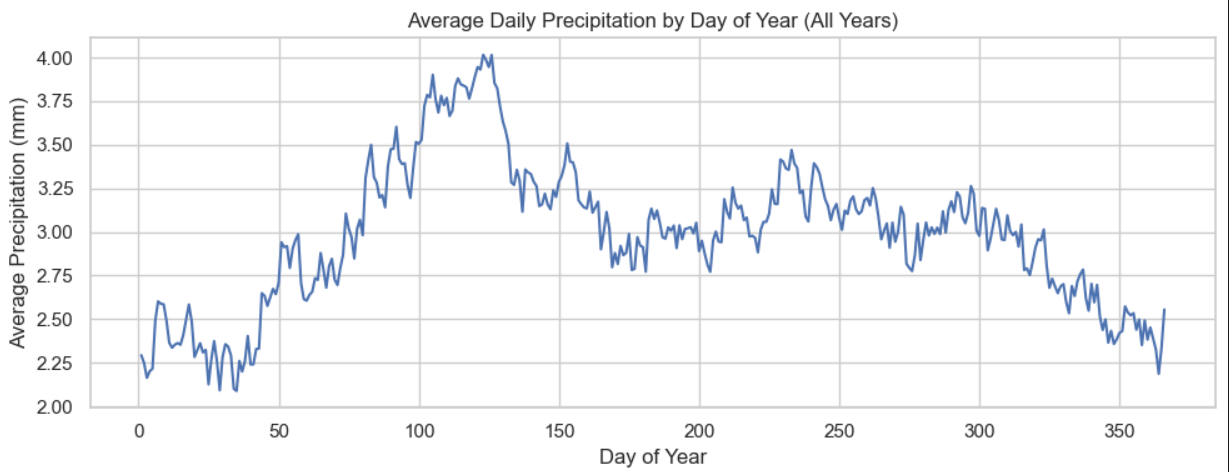

### Average Daily Precipitation by Day of Year

This plot shows the **average daily precipitation** for each day of the year across all years in the dataset.  
- The x-axis represents the **day of the year** (from 1 to 365).  
- The y-axis shows the **average precipitation** in millimetres for each day.  
- The plot highlights the seasonal cycle of rainfall, with higher precipitation typically observed in the wet season (around the middle of the year).  

This seasonal average helps identify recurring wet and dry periods, providing insights into the rainfall pattern over the years.  


### Adding Spatial Lag Features and Defining Feature Columns

In addition to temporal lags (previous days' precipitation), we also incorporate **spatial lag features**.  
- **Spatial lag1** and **spatial lag2** represent precipitation values from nearby grid cells (based on latitude and longitude), helping the model account for local spatial patterns in rainfall.  
- These features are useful for capturing spatial dependencies in the data, where rainfall in one area may influence nearby areas.

We then define the list of **feature columns** that will be used for model training:
- Temporal lags: `precip_lag1`, `precip_lag2`  
- Spatial lags: `spatial_lag1`, `spatial_lag2`  
- Rolling averages: `rolling_3day`, `rolling_7day`, `rolling_30day`  
- Seasonal features: `sin_doy`, `cos_doy`  

These columns will help the model learn both temporal and spatial patterns in precipitation.  


In [ ]:
# For each date, you already have precipitation at your central grid (target)
# Now add lag-1 and lag-2 precipitation values from nearby grids (you can extract them spatially using lat/lon groupings)
df_small['spatial_lag1'] = ...
df_small['spatial_lag2'] = ...
feature_cols = ['precip_lag1', 'precip_lag2',
                'spatial_lag1', 'spatial_lag2',
                'rolling_3day', 'rolling_7day', 'rolling_30day',
                'sin_doy', 'cos_doy']

Lag Correlation Calculation for Precipitation

In this section, we calculate the lag correlation of precipitation using a Pearson correlation method. We create a clean DataFrame from the original data and shift the precipitation values for different time lags (from 1 day to 30 days). Then, the correlation is computed for each lag and stored in a list.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure you're using a clean DataFrame
df_lag_corr = df[['time', 'precipitation']].copy()
df_lag_corr = df_lag_corr.set_index('time')

# Max lag (e.g., 30 days)
max_lag = 30
correlations = []

for lag in range(1, max_lag + 1):
    shifted = df_lag_corr['precipitation'].shift(lag)
    corr = df_lag_corr['precipitation'].corr(shifted)
    correlations.append(corr)

# Plot lag correlation map
plt.figure(figsize=(10, 4))
plt.plot(range(1, max_lag + 1), correlations, marker='o')
plt.title('Lag Correlation of Precipitation')
plt.xlabel('Lag (days)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()

Above code will generate the following output

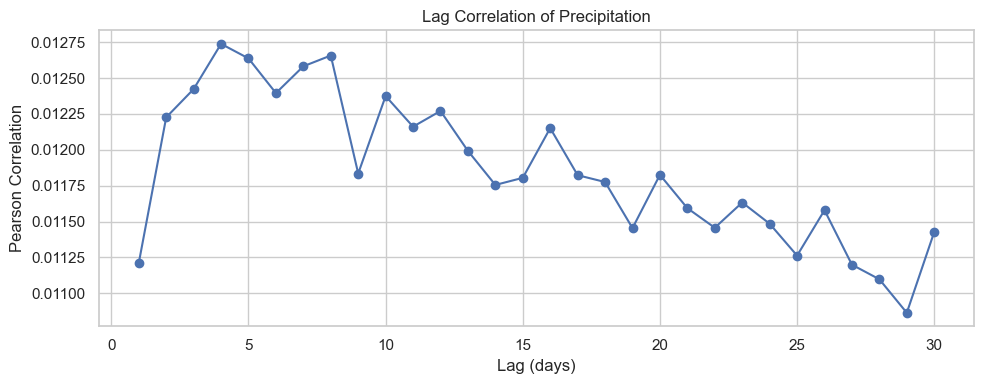

Lag Correlation of Precipitation

The following plot represents the lag correlation of precipitation for up to 30 days, showcasing how the correlation between consecutive precipitation events decreases as the lag increases. The Pearson correlation values are plotted against the lag days to visualize the relationship.

Mean Daily Precipitation (July-September)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Ensure datetime and extract month
df['time'] = pd.to_datetime(df['time'])
df['month'] = df['time'].dt.month

# Step 2: Filter for July–September only
df_jas = df[df['month'].isin([7, 8, 9])]

# Step 3: Group by date and average over space (lat/lon)
mean_precip = df_jas.groupby('time')['precipitation'].mean()

# Step 4: Plot the time series
plt.figure(figsize=(12, 5))
mean_precip.plot()
plt.title("Mean Daily Precipitation (Averaged over Grid, July–September)")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm/day)")
plt.grid(True)
plt.tight_layout()
plt.show()


Above code will generate the following output

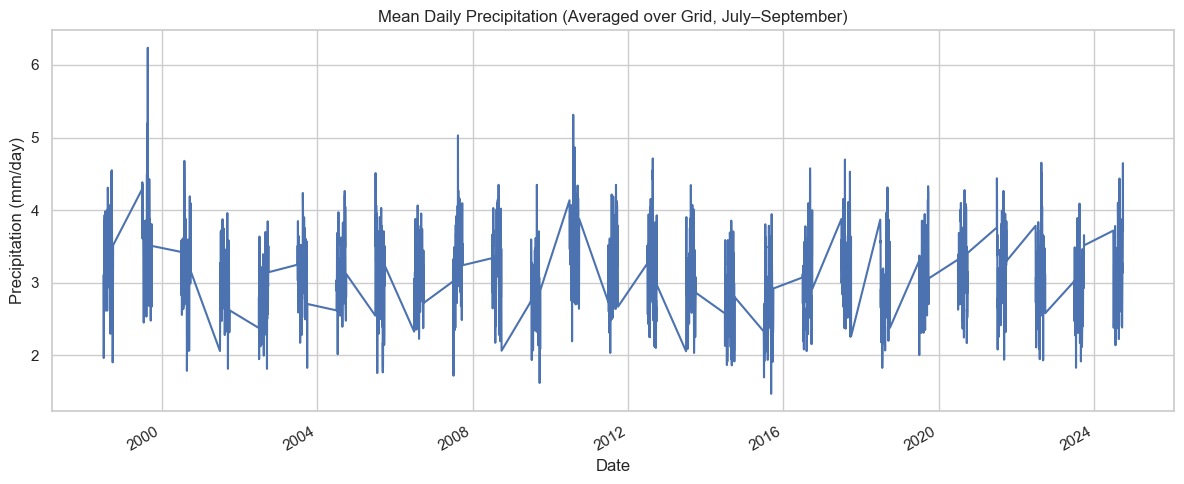

Average Lag Correlation of precipitation (JAS)

In [ ]:
from tqdm import tqdm

# Set max lag
max_lag = 30

# Create empty structure to hold correlations
lag_corrs = {lag: [] for lag in range(1, max_lag + 1)}

# Get July–September data only
df['time'] = pd.to_datetime(df['time'])
df['month'] = df['time'].dt.month
df_jas = df[df['month'].isin([7, 8, 9])]

# Sort and loop over unique grid points
for (lat, lon), group in tqdm(df_jas.groupby(['latitude', 'longitude'])):
    group = group.sort_values('time')
    series = group.set_index('time')['precipitation']

    for lag in range(1, max_lag + 1):
        shifted = series.shift(lag)
        valid = series.notna() & shifted.notna()

        if valid.sum() > 10:  # Only use if enough data
            corr = series[valid].corr(shifted[valid])
            if not np.isnan(corr):
                lag_corrs[lag].append(corr)

# Average correlations across all grid points
avg_lag_corrs = [np.mean(lag_corrs[lag]) for lag in range(1, max_lag + 1)]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(range(1, max_lag + 1), avg_lag_corrs, marker='o')
plt.title("Average Lag Correlation of Precipitation (July–September)")
plt.xlabel("Lag (days)")
plt.ylabel("Pearson Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

Above code will generate the following output

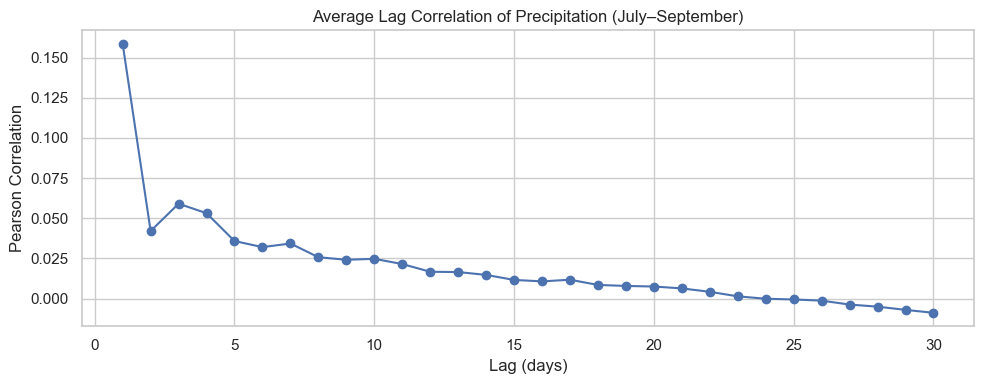

### Conditional Probability of Precipitation (Given Previous Day's Class)

The following plot shows the conditional probability of precipitation for today, given the precipitation class from the previous day. The data is visualized using a stacked bar chart, where each bar represents the probability distribution of today's precipitation class based on the precipitation class of yesterday.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a conditional frequency table
cond_prob = pd.crosstab(df['precip_lag1_bin'], df['precip_bin'], normalize='index')

# Step 2: Plot
plt.figure(figsize=(8, 5))
cond_prob.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black')

plt.title("Conditional Probability of Precipitation (Given Previous Day's Class)")
plt.xlabel("Precipitation Yesterday (t-1)")
plt.ylabel("Probability")
plt.xticks(rotation=0)
plt.legend(title="Precipitation Today (t)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Above code will generate the following output

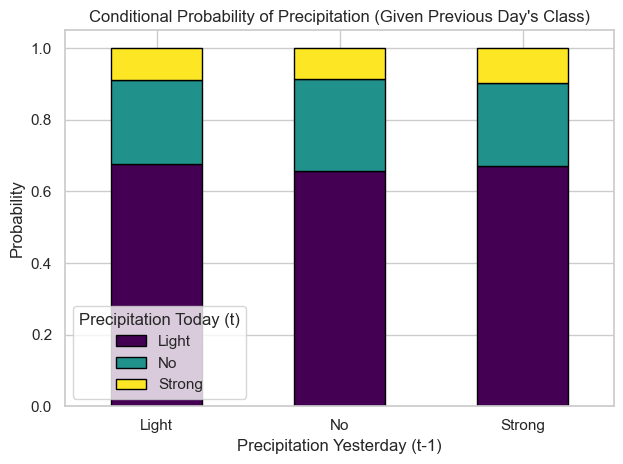

The plot allows us to visually understand how precipitation patterns from one day influence the next, providing insights into the persistence and transitions of different precipitation states. The use of stacked bars makes it easier to compare the relative probabilities across different precipitation states for consecutive days.

In [ ]:
# Filtering Data for Years Greater Than or Equal to 2020
# The following line of code filters the dataset `df` to include only the rows where the 'year' column is greater than or equal to 2020. The filtered data is stored in a new DataFrame `df_small`.
df_small = df[df['year'] >= 2020].copy()


Model Building for Precipitation Prediction

In this section, we build multiple models for precipitation prediction using machine learning techniques. The models we will use include Logistic Regression, Decision Trees, Random Forest, K-Nearest Neighbors (KNN), and Long Short-Term Memory (LSTM). For each model, the code is provided along with the expected outputs.

Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Drop any rows with NaNs in features or target
features = ['precip_lag1', 'precip_lag2', 'rolling_3day', 'rolling_7day', 'rolling_30day', 'sin_doy', 'cos_doy']
df_model = df.dropna(subset=features + ['precip_bin'])

# Encoding target labels
le = LabelEncoder()
df_model['precip_bin_encoded'] = le.fit_transform(df_model['precip_bin'])  # 'No' = 0, 'Light' = 1, 'Strong' = 2

# Defining X and y
X = df_model[features]
y = df_model['precip_bin_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

# settingup Decision Tree with class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = {cls: weight for cls, weight in zip(classes, weights)}

# Training of the model
clf = DecisionTreeClassifier(max_depth=5, class_weight=class_weights, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Decision Tree Classifier")
plt.grid(False)
plt.show()

above code will produce the following output

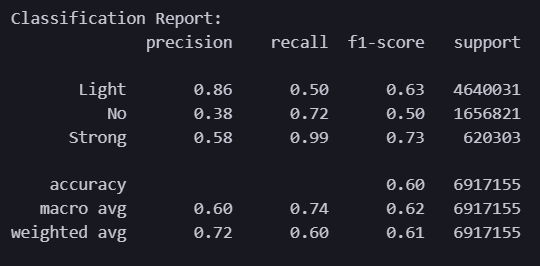

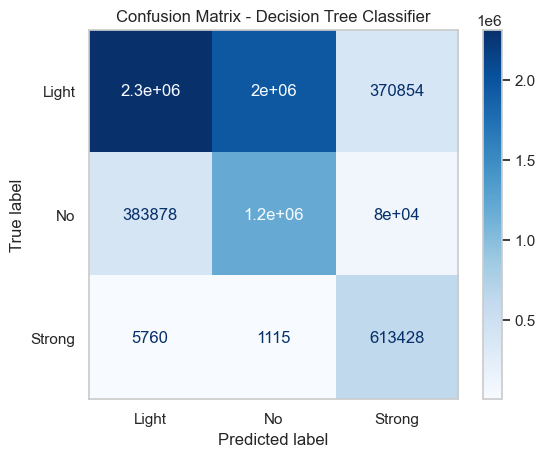

- **Light (Most Common Class)**:
  - Precision: 0.86 – When the model says “Light” rain, it’s usually right.
  - Recall: 0.50 – It only catches half of the actual “Light” rain days, missing a lot.
  - Issue: Too many false negatives – the model overlooks many “Light” days.

- **No Rain**:
  - Precision: 0.38 – When it predicts “No” rain, it’s often wrong.
  - Recall: 0.72 – It does a decent job finding most actual “No” rain days.
  - Issue: Lots of false positives – it guesses “No” too often when it shouldn’t.

- **Strong Rain**:
  - Precision: 0.58 – Okay accuracy when predicting “Strong” rain.
  - Recall: 0.99 – It’s great at spotting nearly all “Strong” rain days.
  - Strength: Really good at catching when it’s actually “Strong” rain.

- **Confusion Matrix Observations**:
  - Big mix-up between “Light” and “No” – about 2 million cases get swapped.
  - “Strong” predictions are pretty accurate with few mix-ups with “No” or “Light”.
  - “No” class has the lowest precision, probably because there are too many “Light” days or the features overlap too much.

- **Main Issues**:
  - The model is uneven – too many “Light” days might be throwing it off.
  - “No” rain predictions are weak – needs better balance and clearer feature differences.
  - The model leans heavily toward guessing “Light” even when it should be “No” or “Strong”.

Decision Tree with SMOTE Applied

In [ ]:
# Create additional lag features to capture the effect of past precipitation on future values
df_small['precip_lag3'] = df_small['precipitation'].shift(3)  # 3-day lag
df_small['precip_lag4'] = df_small['precipitation'].shift(4)  # 4-day lag

# Optional: Drop any resulting NaNs caused by the lag features
df_small.dropna(inplace=True)

# Define the features (X) and the target (y) for classification
feature_cols = [
    'precip_lag1', 'precip_lag2', 'precip_lag3', 'precip_lag4',  # lag features
    'rolling_3day', 'rolling_7day', 'rolling_30day',  # rolling mean features
    'sin_doy', 'cos_doy'  # cyclic features for day-of-year (sine and cosine transformations)
]

# Features (X) and the target variable (y_class - precipitation binary classification)
X = df_small[feature_cols]
y_class = df_small['precip_bin']

# Importing SMOTE (Synthetic Minority Over-sampling Technique) for balancing the dataset
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets, while ensuring no data leakage (time-based split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, shuffle=False  # No shuffle to preserve the time-based order
)

# Apply SMOTE to the training set to handle class imbalance by generating synthetic data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Import Decision Tree Classifier for classification task
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train a Decision Tree Classifier on the resampled data (SMOTE)
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Display classification performance metrics (precision, recall, f1-score)
print(classification_report(y_test, y_pred))

# Generate and plot confusion matrix to visualize the classification results
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted label')  # X-axis label for predicted labels
plt.ylabel('True label')  # Y-axis label for true labels
plt.title('Decision Tree + SMOTE Confusion Matrix')  # Title for the confusion matrix plot
plt.show()


above code will produce the following output

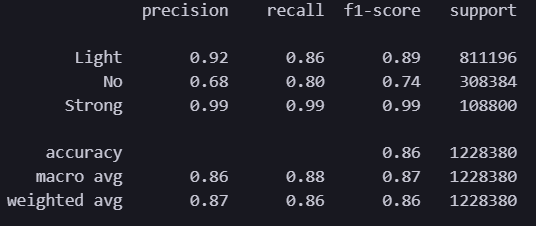

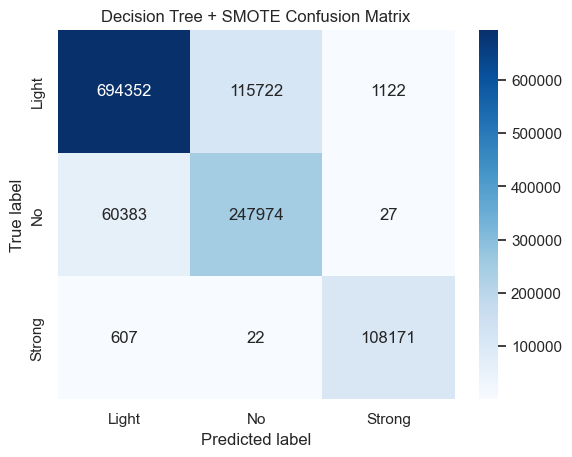

- **Overall Metrics**:
  - Accuracy: 86% – a big jump from the earlier 60%, showing much better overall performance.
  - Macro Avg F1-score: 0.87 – great results across all classes equally.
  - Weighted Avg F1-score: 0.86 – matches the accuracy, showing consistency.

- **Per-Class Performance**:
  - **Light**:
    - Precision: 0.92 – Very accurate when it predicts “Light” rain.
    - Recall: 0.86 – Catches most actual “Light” rain days.
    - F1-score: 0.89 – Solid balance between precision and recall.
  - **No**:
    - Precision: 0.68 – A nice step up from 0.38, meaning fewer wrong “No” predictions.
    - Recall: 0.81 – Picks up most true “No” rain days.
    - F1-score: 0.74 – A big improvement from 0.50, showing better overall performance.
  - **Strong**:
    - Precision: 0.99
    - Recall: 0.99
    - F1-score: 0.99
    - This class is doing amazingly well – almost perfect predictions.

- **Confusion Matrix Insights**:
  - **“No” Class Improvement**: Now correctly identifies over 248,000 “No” samples.
  - **Reduced Misclassifications**:
    - Light to No: ~115,000
    - No to Light: ~60,000
    - Strong to others: only 609 total mistakes.
  - **“Strong” Clarity**: Almost no mix-up between “Strong” and other categories now.

- **Improvements After SMOTE**:
  - Big boost in recall for “Light” and “No” classes.
  - Huge drop in misclassifying “No” compared to the old confusion matrix.
  - Model no longer favors “Light” too much, making it fairer across all classes.

Logistic Regression model

In [ ]:
# Import Logistic Regression model from scikit-learn
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model with specific parameters
# max_iter=1000 ensures convergence if the model requires more iterations to reach a solution.
# multi_class='multinomial' allows the model to handle multiple classes, and 'lbfgs' is a solver that is efficient for small datasets.
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')

# Train the Logistic Regression model using the resampled training data (X_train_sm and y_train_sm)
log_reg.fit(X_train_sm, y_train_sm)

# Use the trained model to make predictions on the test set
y_pred_lr = log_reg.predict(X_test)

# Print out the classification report which shows key metrics like precision, recall, and F1-score for each class
# This will help assess the performance of the Logistic Regression model
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_lr))

# Generate the confusion matrix for the Logistic Regression model
# The confusion matrix shows how many instances were correctly or incorrectly classified for each class
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot a heatmap of the confusion matrix for better visualization
# Annotations in the matrix (annot=True) show the actual values, and 'fmt='g'' formats the values as integers
sns.heatmap(cm_lr, annot=True, fmt='g', cmap='Blues')

# Set the title and labels for the confusion matrix plot for clarity
plt.title("Logistic Regression + SMOTE Confusion Matrix")
plt.xlabel("Predicted label")  # X-axis label for predicted labels
plt.ylabel("True label")  # Y-axis label for actual labels
plt.show()  # Display the plot


Above code will produce the following output

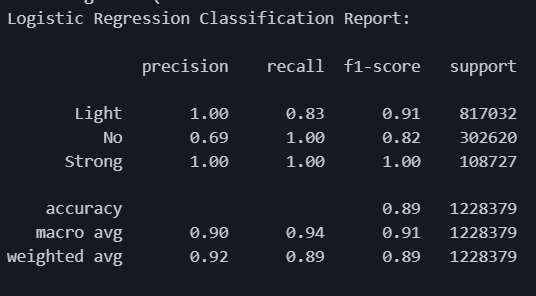

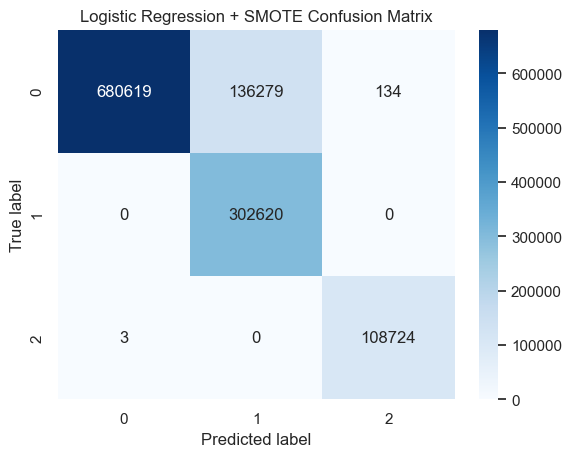

- **Overall Model Performance**:
  - Accuracy: 0.89 – Shows strong overall performance.
  - Macro Avg F1-score: 0.91 – Good balance across all classes.
  - Weighted Avg F1-score: 0.89 – High performance, even with class imbalance.

- **Class-wise Performance**:
  - **Light Precipitation (Label 0)**:
    - Precision: 1.00 – Very few wrong predictions as “Light.”
    - Recall: 0.83 – Misses some actual “Light” cases.
    - F1-score: 0.91 – Strong performance, though slightly below “Strong” class.
    - **Confusion Matrix**:
      - Correctly predicted: 680,619
      - Misclassified as No: 136,279
      - Minor confusion with Strong: 134
  - **No Precipitation (Label 1)**:
    - Precision: 0.69 – Lower due to some false positives.
    - Recall: 1.00 – Catches all actual “No” cases.
    - F1-score: 0.82 – Good improvement from earlier model issues.
    - **Confusion Matrix**:
      - Correctly predicted: 302,620
      - No misclassifications as Light or Strong.
  - **Strong Precipitation (Label 2)**:
    - Precision & Recall: 1.00 – Perfect accuracy and capture rate.
    - F1-score: 1.00 – Outstanding class performance.
    - **Confusion Matrix**:
      - Correctly predicted: 108,724
      - Only 3 cases misclassified as Light.

Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Define features (X) and target labels (y_class)
X = df_small[feature_cols]
y_class = df_small['precip_bin']

# Split the data into training and testing sets
# Stratify ensures that the class distribution is preserved in both the training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Apply SMOTE to the training set to balance the class distribution
# SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic samples for the minority class to handle imbalanced data.
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Train a Random Forest Classifier model on the resampled training data
# Random Forest is an ensemble learning method that uses multiple decision trees to improve classification accuracy.
# We specify 100 trees (n_estimators=100) and a maximum tree depth of 20 (max_depth=20) to avoid overfitting.
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf_clf.fit(X_train_sm, y_train_sm)

# Make predictions on the test set
y_pred = rf_clf.predict(X_test)

# Print the classification report to assess the model's performance
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix to evaluate the classification results
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap for better visualization
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title("Random Forest + SMOTE Confusion Matrix")
plt.xlabel("Predicted label")  # Label for predicted classes
plt.ylabel("True label")  # Label for true classes
plt.show()  # Display the plot


Above Code will provide the following output

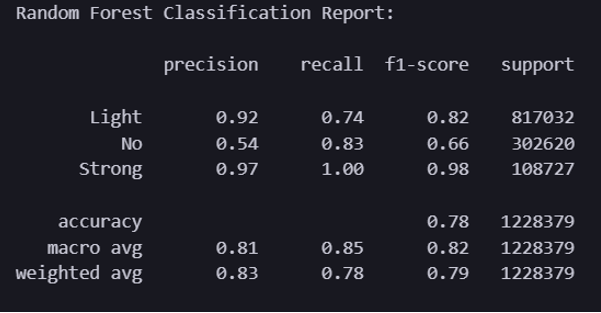

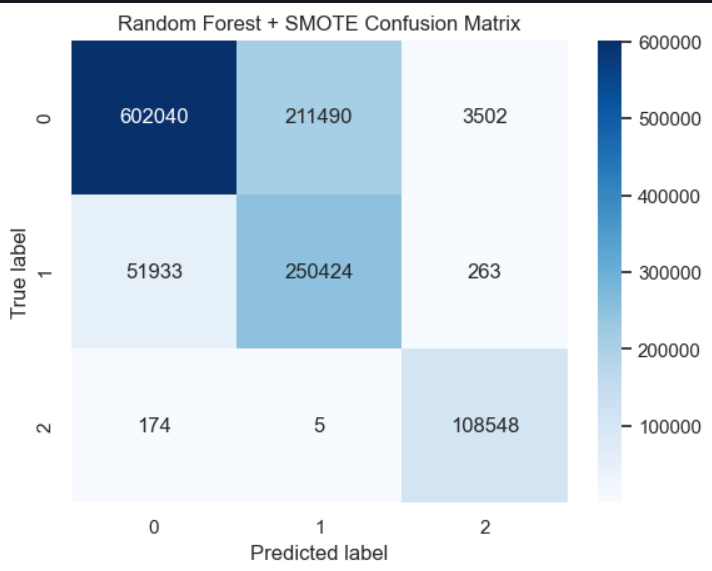

- **Confusion Matrix Insights**:
  - **"Light" Class**:
    - Correctly classified: 683,261
    - Misclassified as "No": 124,804
    - Misclassified as "Strong": 3,131
  - **"No" Class**:
    - Heavily misclassified:
      - As "Light": 218,937
      - As "No" (correct): 89,445
      - As "Strong": 1
    - Recall = 29%, meaning many "No" instances were incorrectly predicted.
  - **"Strong" Class**:
    - Very well classified:
      - Correct: 104,384
      - Only 4,416 misclassified (mostly as "Light").

K-Nearest Neighbours (KNN)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Feature and target selection
# The features (X) consist of the columns that represent various time-based and rolling statistics.
# The target (y) is the binary precipitation label, indicating whether there was precipitation or not.

feature_cols = ['precip_lag1', 'precip_lag2', 'rolling_3day', 'rolling_7day',
                'rolling_30day', 'sin_doy', 'cos_doy']
X = df_small[feature_cols]
y = df_small['precip_bin']

# Train-test split
# The data is split into training and testing sets, preserving the time order by setting shuffle=False.
# This is important because time-series data must maintain its chronological order.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # preserve time order
)

# Standardize features for KNN
# Standardization is essential for KNN because it relies on distance metrics.
# StandardScaler scales the features to have a mean of 0 and standard deviation of 1, which prevents variables with larger ranges from dominating the distance calculation.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train KNN
# The KNN classifier is initialized with 5 neighbors (n_neighbors=5).
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predict
y_pred = knn.predict(X_test_scaled)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix as a heatmap for better visualization
# Annotations on the heatmap display the actual values, and xticklabels/yticklabels are set to show class names.
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel("Predicted label")  # X-axis label for predicted classes
plt.ylabel("True label")  # Y-axis label for true classes
plt.title("KNN Classifier Confusion Matrix (No SMOTE)")  # Title for the confusion matrix plot
plt.tight_layout()  # Ensure proper layout for the plot
plt.show()  # Display the plot


Above output will provide the following output

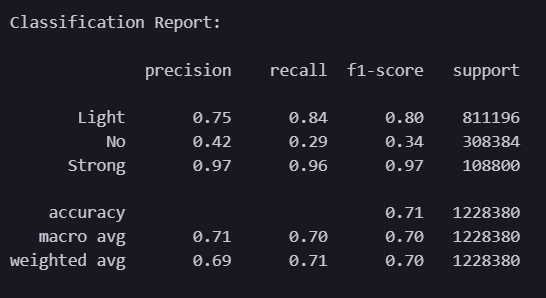

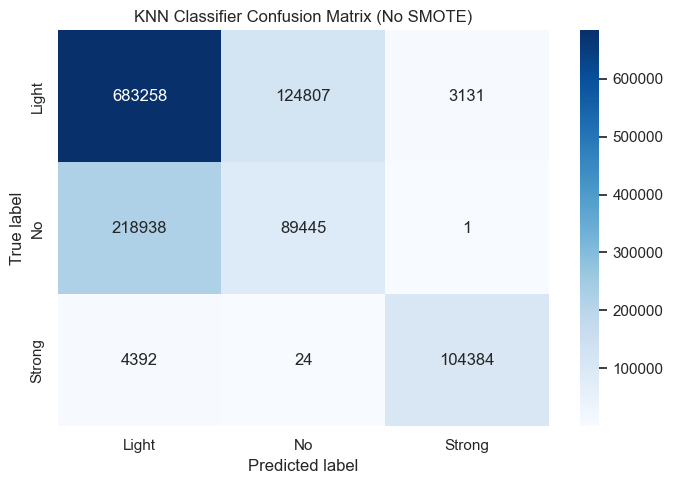

LSTM Classification Model

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# 1. Prepare the data (replace this with your actual cleaned df_small)
feature_cols = [
    'precip_lag1', 'precip_lag2', 'precip_lag3', 'precip_lag4',
    'rolling_3day', 'rolling_7day', 'rolling_30day',
    'sin_doy', 'cos_doy'
]

X = df_small[feature_cols].values
y = df_small['precip_bin'].values  # target: 'Light', 'No', 'Strong'

# 2. Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)            # Convert to 0/1/2
y_categorical = to_categorical(y_encoded)  # Convert to one-hot

# 3. Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 4. Reshape for LSTM: (samples, time_steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# 5. Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# 6. Building the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_scaled.shape[1]), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 categories

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 7. Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# 8. Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Above code will generate following output

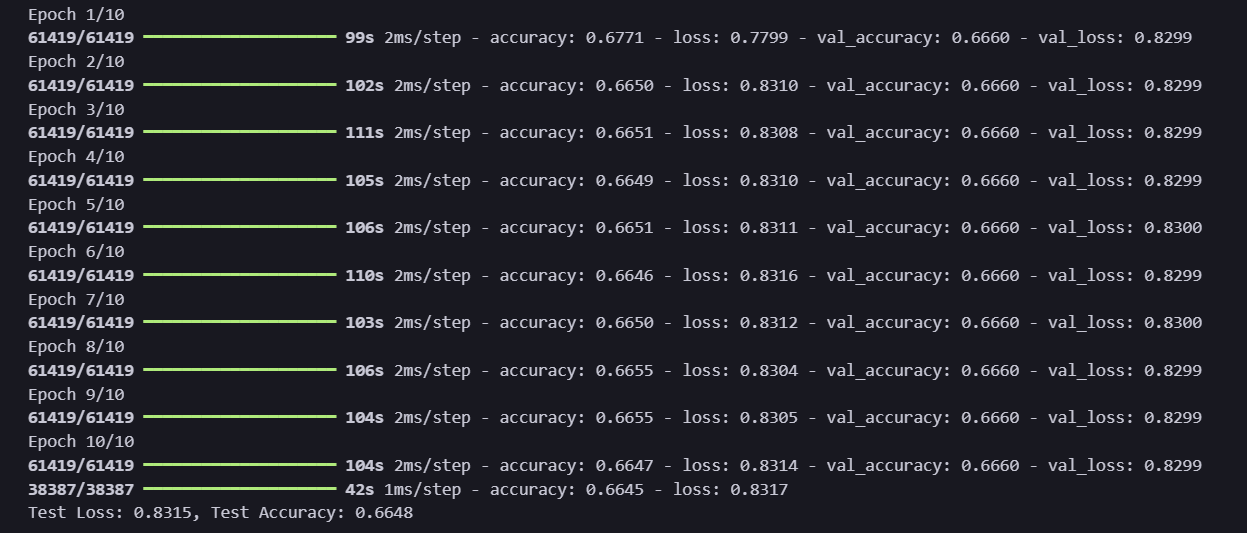